This notebook solve the less thank problem by making use of Grover's algorithm for searching in the list. The algorithm makes use of an oracle that compares two bitstrings and marks those that are less than k.

In [9]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from qiskit.primitives import BackendSampler
import numpy as np
from qiskit.circuit.library import MCMT, ZGate
from collections import Counter
import math
import warnings
from qiskit import QuantumCircuit
from qiskit.circuit.library import GroverOperator, MCMT, ZGate
from qiskit.visualization import plot_distribution
from qiskit.visualization import plot_histogram

warnings.filterwarnings("ignore")

def bit_compare():
    """
    Creates a quantum circuit to compare two qubits.
    
    This function generates a quantum circuit designed to compare two bits. It sets up
    a control mechanism to determine if the bits are equal or not, using auxiliary qubits
    for intermediate calculations.
    
    Returns:
        QuantumCircuit: A quantum circuit for comparing two bits.
    """

    # Initialize quantum registers for the input bits and auxiliary bits
    qr = QuantumRegister(2, "bits")
    aux = QuantumRegister(2, "aux")
    
    # Create the quantum circuit using the registers
    qc = QuantumCircuit(qr, aux)

    # Apply quantum gates to perform the comparison logic
    qc.x(qr[1])
    qc.mcx(qr, aux[0])
    qc.x(qr[0])
    qc.x(qr[1])
    qc.mcx(qr, aux[1])
    qc.x(qr[0])
    
    return qc

def encode(bit):
    """
    Encodes a classical bit into a quantum bit.
    
    Given a classical bit as a string ('0' or '1'), this function encodes it into a 
    quantum bit (qubit) by applying an X gate if the bit is '1', effectively setting 
    the qubit to |1⟩ state.
    
    Parameters:
        bit (str): A classical bit represented as a string, either '0' or '1'.
    
    Returns:
        QuantumCircuit: A quantum circuit with a single qubit encoded with the input bit.
    """

    # Initialize a quantum register for a single qubit
    qr = QuantumRegister(1, "number")

    # Create the quantum circuit
    qc = QuantumCircuit(qr)

    # If the input bit is '1', apply an X gate to flip the qubit to |1⟩ state
    if (bit == "1"):
        qc.x(qr[0])
    return qc

def compare_bitstring(bitstring_a, bitstring_b, exec=True):
    """
    Compares two bitstrings using a quantum circuit.
    
    This function constructs and executes a quantum circuit to compare two bitstrings
    bit by bit. It leverages the quantum bit comparison logic to determine if bitstring_a
    is less than, greater than, or equal to bitstring_b.

    Parameters:
        bitstring_a (str): The first bitstring to compare.
        bitstring_b (str): The second bitstring to compare.
        exec (bool): If True, execute the quantum circuit and return the comparison result;
                     otherwise, return the constructed quantum circuit without executing.
    
    Returns:
        QuantumCircuit or int/str: Depending on the value of exec, returns either the quantum circuit
                                   constructed for the comparison, or the outcome of the comparison:
                                   0 if bitstring_a > bitstring_b, 1 if bitstring_a < bitstring_b, 
                                   or "equal" if they are the same.
    """

    # Determine the number of bits for the quantum registers based on the first bitstring
    bits = len(bitstring_a)

    # Initialize quantum and classical registers for the comparison
    qra = QuantumRegister(bits, "a")
    qrb = QuantumRegister(bits, "b")
    qraux = QuantumRegister(2*bits, "aux")
    qrint = QuantumRegister(bits-1, "int")
    cr = ClassicalRegister(2)

    # Construct the quantum circuit
    qc = QuantumCircuit(qra, qrb, qraux, qrint, cr)
    
    # Loop through each bit in the bitstrings to set up the comparison logic
    for i in range(bits):
        qc.append(encode(bitstring_a[i]), [qra[i]])
        qc.append(encode(bitstring_b[i]), [qrb[i]])
        qc.append(bit_compare(), [qra[i], qrb[i], qraux[2*i], qraux[2*i+1]])

        # Apply logic to determine if further comparison is needed based on previous bits
        if i < bits-1:
            qc.x(qraux[2*i])
            qc.x(qraux[2*i+1])
            qc.mcx([qraux[2*i], qraux[2*i+1]], qrint[i])
            qc.x(qraux[2*i])
            qc.x(qraux[2*i+1])
        
    for i in range(0, bits-1):
        qc.mcx([qraux[2*(-i-1)],  qrint[-i]], qraux[2*(-i)])
        qc.mcx([qraux[2*(-i-1)+1],  qrint[-i]], qraux[2*(-i)+1])
    
    # Measure the final outcome of the comparison
    qc.measure(qraux[0], cr[0])
    qc.measure(qraux[1], cr[1])
    
    if exec:
        # Measure the final outcome of the comparison
        backend = Aer.get_backend('qasm_simulator')
        transpiled_circuit = transpile(qc, backend)
        job = backend.run(transpiled_circuit, shots=1000)
        result = job.result()
        counts = result.get_counts()

        if "01" in counts:
            return 0 # bitstring_a > bitstring_b
        elif "10" in counts:
            return 1 # bitstring_a < bitstring_b
        elif "00" in counts:
            return "equal" # bitstrings are equal

    else:
        return qc

def trim_to_length(bitstring, target_length):
    """
    Trims leading zeros from a bitstring up to a certain fixed length.
    
    Parameters:
        bitstring (str): The bitstring to trim.
        target_length (int): The target minimum length of the bitstring after trimming.
        
    Returns:
        str: The trimmed bitstring with a length of at least target_length.
    """
    # Calculate the number of leading zeros to remove
    num_to_remove = len(bitstring) - target_length
    
    # Trim leading zeros only if the number to remove is positive
    if num_to_remove > 0:
        # Count total leading zeros
        leading_zeros = len(bitstring) - len(bitstring.lstrip('0'))
        
        # Remove the smaller of total leading zeros or num_to_remove
        zeros_to_remove = min(leading_zeros, num_to_remove)
        
        # Remove the calculated number of zeros
        trimmed_bitstring = bitstring[zeros_to_remove:]
    else:
        trimmed_bitstring = bitstring
    
    return trimmed_bitstring
    
def grover_oracle(k, l, num_qubits):
    """
    Builds a Grover oracle for identifying marked states where the bitstring is less
    than a specified key, utilizing trimmed bitstring comparison.
    
    The function compares each state in the list `l` against the key `k`, marking states
    where the comparison determines that the state is less than `k`. It constructs a 
    quantum circuit implementing this logic, marking appropriate states with a phase flip.

    Parameters:
        k (str): The key bitstring to compare against.
        l (list): A list of bitstrings representing the states to be compared to `k`.
        num_qubits (int): The number of qubits in the circuit.

    Returns:
        QuantumCircuit: The constructed quantum circuit implementing the oracle.
        int: The number of marked states identified by the oracle.
    """

    qc = QuantumCircuit(num_qubits)
    marked_states=[]

    # Identify marked states based on the comparison result
    for i in l:
        size_bitstring=max(len(i.lstrip("0")), len(k.lstrip("0")))
        if compare_bitstring(trim_to_length(k, size_bitstring), trim_to_length(i, size_bitstring), exec=True)==0:
            marked_states.append(i)

    # Implement phase flip for each marked state
    for target in marked_states:
        rev_target = target[::-1] # Reverse bit order to match Qiskit's endianness
        zero_inds = [ind for ind in range(num_qubits) if rev_target.startswith("0", ind)]
        qc.x(zero_inds)
        qc.compose(MCMT(ZGate(), num_qubits - 1, 1), inplace=True)
        qc.x(zero_inds)
    
    return qc, len(marked_states)


def less_than_k(k, list):
    """
    Implements a Grover search to find elements in a list that are less than a specified
    value `k`. Constructs and runs a quantum circuit to perform the search, and returns
    the most relevant states based on their occurrence frequency.
    
    Parameters:
        k (int): The key value to compare the list elements against.
        l (list): The list of integer values to be searched through.

    Returns:
        list: The list of integers from `l` that are less than `k` and most frequently
              observed in the measurement outcomes.
        QuantumCircuit: The Grover oracle circuit used in the search.
        GroverOperator: The Grover operator constructed for the search.
        QuantumCircuit: The final quantum circuit used for the Grover search.
    """

    # Convert list elements to binary strings and pad to equal length
    l_bin=[bin(i)[2:] for i in list]
    length_bitstring=max([len(element) for element in l_bin])
    l_bin=[i.zfill(length_bitstring) for i in l_bin]

    # Construct the Grover oracle for the search
    oracle = grover_oracle(bin(k)[2:].zfill(length_bitstring), l_bin, length_bitstring)[0]
    number_marked_elements=grover_oracle(bin(7)[2:].zfill(length_bitstring), l_bin, length_bitstring)[1]

    # Construct the Grover operator based on the oracle
    grover_op = GroverOperator(oracle)

    # Calculate the optimal number of Grover iterations based on the number of marked elements
    optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(number_marked_elements/ 2**grover_op.num_qubits)))
    ) 

    # Prepare the quantum circuit for Grover's algorithm
    qc = QuantumCircuit(grover_op.num_qubits)
    qc.h(range(grover_op.num_qubits)) # Create a superposition of all states
    qc.compose(grover_op.power(optimal_num_iterations), inplace=True) # Apply Grover's algorithm
    qc.measure_all()

    # Execute the quantum circuit
    backend = Aer.get_backend('qasm_simulator')
    shots = 10000
    transpiled_circuit = transpile(qc, backend)
    job = backend.run(transpiled_circuit, shots=1000)
    result = job.result()
    counts = result.get_counts(qc)
    #plot_histogram(counts)

    #Identify the top N most frequent states that are less than k
    top_N_states = Counter(counts).most_common(number_marked_elements)
    list_result=[int(str(i[0]), 2) for i in top_N_states]
    
    return list_result, oracle, grover_op, qc

In [10]:
l=[4,9,11,14,1,13,6,15, 0, 2, 30]
result=less_than_k(7, l)
list_less_than_k=result[0]

In [11]:
list_less_than_k

[1, 0, 6, 4, 2]

Circuit representations

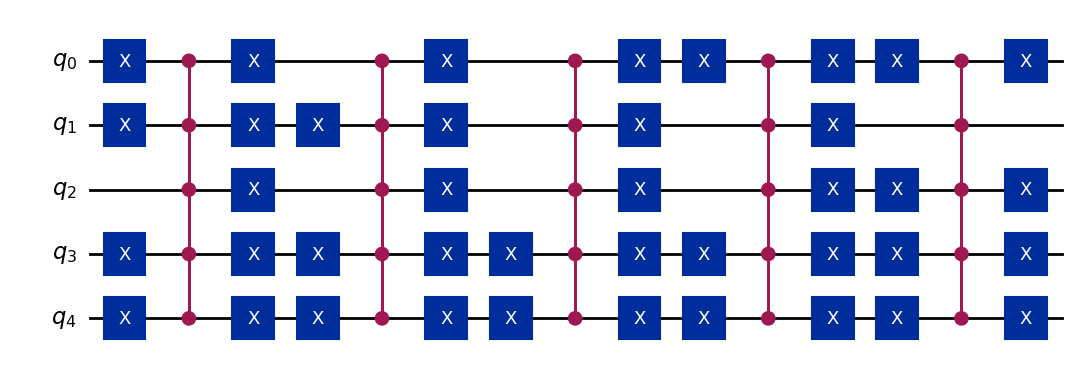

In [12]:
result[1].draw(output="mpl", style="iqp") #Oracle

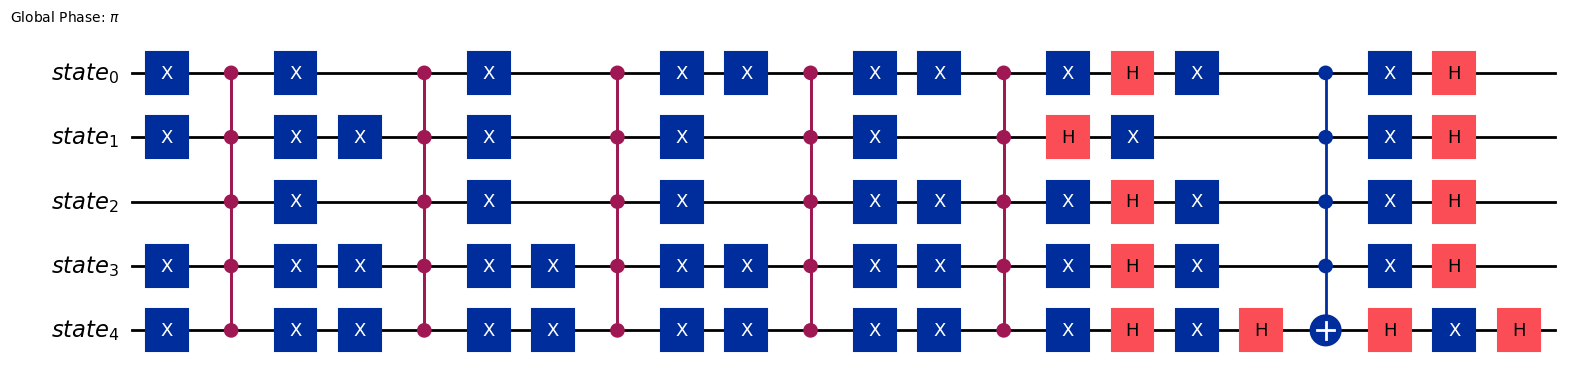

In [13]:
result[2].decompose().draw(output="mpl", style="iqp") #Grover operator

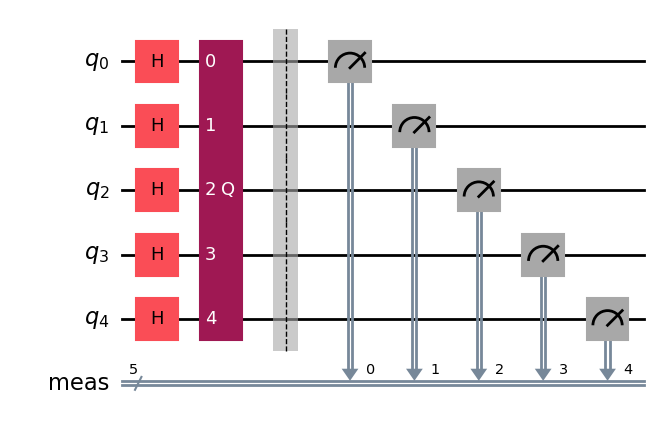

In [14]:
result[3].draw(output="mpl", style="iqp") #Quantum circuit